In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from imageio import imread
from skimage.transform import resize
from scipy.spatial.distance import hamming
from lsh import LSH
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics.pairwise import rbf_kernel
import copy

%load_ext autoreload
%autoreload 2

----
# 1. Data

## 1.1 Random Data

In [ ]:
n = 10000 #data points
d = 64  #data dimensionality

#Random Data : (d,n)
X = np.random.normal(0,1,(d,n))
X = X/np.linalg.norm(X,keepdims=True,axis=0)

#Query : (d,1)
q = np.random.normal(0,1,(d,1))
q = q/np.linalg.norm(q,keepdims=True,axis=0)

## 1.2 Image Data

In [2]:
QUERIES_PER_PLOT = 5
PLOTS_PER_QUERY = 7
IMSIZE = (224, 224)

FILE_FEATURES = "imnet-val/cnn-50000.p"
PATH_IMGS = "imnet-val/val/"

In [3]:
data = None
with open(FILE_FEATURES, 'rb') as f:
    data = pickle.load(f)
fnames = data['fnames']

In [4]:
X = data['all_vecs'].T
X = X/np.linalg.norm(X,keepdims=True,axis=0)

q_index = 32
q = copy.deepcopy(X[:,q_index:q_index+1])
X[:,q_index:q_index+1] = np.mean(X,keepdims=True,axis=1) #replace with dummy features

d,n = X.shape

In [5]:
def get_img_path(idx):
    return PATH_IMGS + fnames[idx][48:]

def get_img(idx):
    full_name = get_img_path(idx)
    img = imread(full_name)
    img = resize(img, IMSIZE, anti_aliasing=True, mode='reflect')
    return img
def plt_img(idx):
    plt.imshow(get_img(idx))
    plt.axis('off')
    plt.gca().set_aspect('equal')

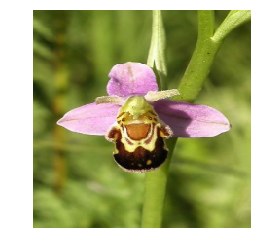

In [6]:
plt_img(q_index)
plt.show()

# 2. Distance Metric

In [7]:
def cos_sim(X,q):
    """
    Returns the cosine similarity between each
    column of X and the (single) column of q.
    """
    ip = (q.T@X).flatten()
    norm_x = np.linalg.norm(X,axis=0)
    norm_q = np.linalg.norm(q,axis=0)
    ratio = ip/norm_x/norm_q
    ratio = np.minimum(ratio,1)
    ratio = np.maximum(ratio,-1)
    sim = 1 - np.arccos(ratio)/np.pi
    return sim

In [8]:
sims = cos_sim(X,q)
sims_dec = np.sort(sims)[::-1]
sims_ranked = np.argsort(sims)[::-1]

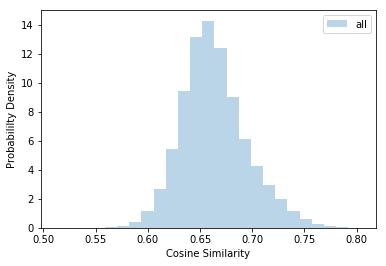

In [9]:
plt.hist(sims,bins=25,alpha=0.3,density=True,label="all")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Probabililty Density")
plt.show()

In [10]:
rbfs = np.zeros(n)
for i in range(n):
    ip = float(rbf_kernel(q[:,0].reshape(1,-1),X[:,i].reshape(1,-1),gamma=10e-1))
    rbfs[i] = ip

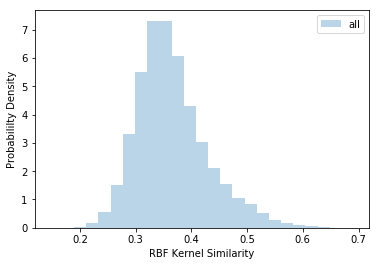

In [11]:
plt.hist(rbfs,bins=25,alpha=0.3,density=True,label="all")
plt.legend()
plt.xlabel("RBF Kernel Similarity")
plt.ylabel("Probabililty Density")
plt.show()

**Note:** RBF Kernel Similarity gives a much better seperation of data. Notice the long tail. Theres a few items that are "close" to query, and most are clustered at a further distance.

In [12]:
def get_weights(k):
    return (1/np.log2(np.arange(k)+2))**0.9

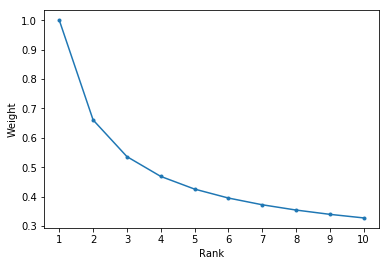

In [13]:
k = 10
xs = np.arange(k)+1
ws = get_weights(k)
plt.plot(xs,ws,'.-')
plt.xticks(xs)
plt.xlabel('Rank')
plt.ylabel('Weight')
plt.show()

In [14]:
def ndcg(k,c):
    """
    Normalized discounted cumulative gain @ k
    c denotes a list of ranked indices for the
    query q into X. Assumes sims and sims_dec
    have already been computed. c can contain
    less than k choices, but this only leads to
    a lower ndcg score.
    """
    assert(len(c)<=k)
    #Gain for Supplied Choices
    w_c = get_weights(len(c))
    s_c = sims[c]
    gain_c = np.inner(s_c,w_c)
    
    #Optimal Gain
    w = get_weights(k)
    s_opt = sims_dec[:k]
    gain_opt = np.inner(s_opt,w)
    
    #Ratio
    ndcg = gain_c/gain_opt
    return ndcg

In [15]:
k = 3
print(ndcg(k,[2,4,5]))
print(ndcg(k,[2,4]))
print(ndcg(k,sims_ranked[:k]))

0.8489904891564682
0.6375138873909519
1.0


In [16]:
def hamming_dist(H_data,H_q):
    assert(H_data.shape[0]==H_q.shape[0])
    assert(H_q.shape[1]==1)
    b = H_data.shape[0]
    return np.sum(1*(H_data-H_q != 0),axis=0)/b

-----
# 2. LSH

In [17]:
b = 200 #hash bits
M = 30  #number of permutations
B = 1   #number of neighbors to make candidates
k = 10  #k-NN
model = LSH(X,b,M,b)

H_data = model.H_data
H_q    = model._get_hash(q)

----
# 3. Experiments

## 3.1 Distance Preservation

In [18]:
hds = hamming_dist(H_data,H_q)

In [19]:
def binom(b,probs,complement=False):
    if complement:
        mean = b*(1-probs)
    else:
        mean = b*probs
    std = np.sqrt(b*probs*(1-probs))
    return mean,std

def binom_conf(b,probs,complement=False):
    mean, std = binom(b,probs,complement)
    counts = np.array(mean,dtype=np.int32)
    ci = [_ for _ in proportion_confint(counts,b,0.05,"wilson")]
    return ci

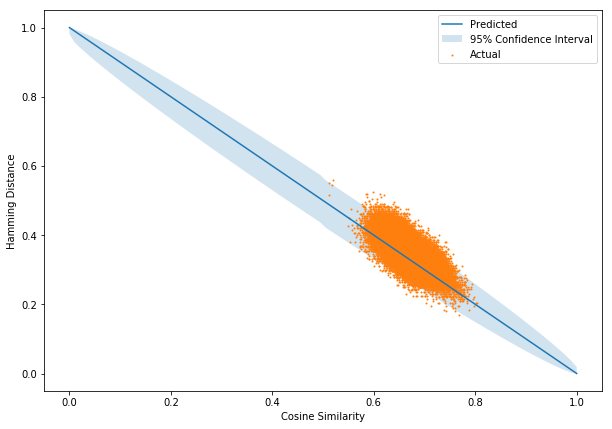

In [38]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

#Predicted relashionship with confidence interval
plt.plot([0,1],[1,0],label="Predicted")
x  = np.linspace(0,1,100)
ci = binom_conf(b,x,True)
plt.fill_between(x,ci[0],ci[1],alpha=0.2,label="95% Confidence Interval")

#Actual observed relationship
plt.scatter(sims,hds,s=1,label="Actual")

plt.xlabel("Cosine Similarity")
plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

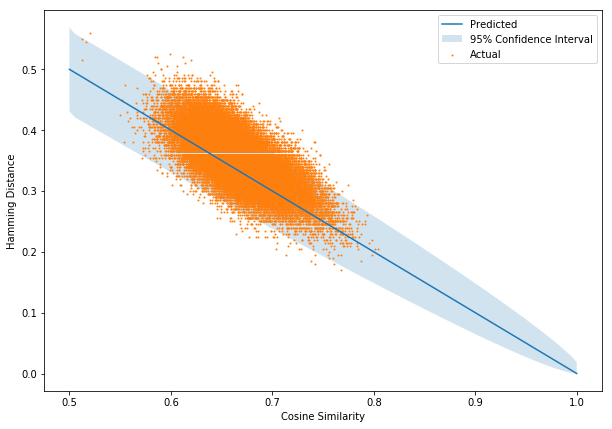

In [40]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

#Predicted relashionship with confidence interval
plt.plot([0.5,1],[0.5,0],label="Predicted")
x  = np.linspace(0.5,1,100)
ci = binom_conf(b,x,True)
plt.fill_between(x,ci[0],ci[1],alpha=0.2,label="95% Confidence Interval")

#Actual observed relationship
plt.scatter(sims,hds,s=1,label="Actual")

plt.xlabel("Cosine Similarity")
plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

## 3.2 NDCG Ablative Analysis

In [21]:
rank_0_opt    = sims_ranked[:k]
rank_1_hd     = np.argsort(hds)[:k]
rank_2_lsh_hd = model.approx_top_k(q,k,refine="hamming")
rank_3_lsh_ip = model.approx_top_k(q,k,refine="innerprod")
assert((model.exact_top_k(q,k) == rank_0_opt).all())

ndcg_0_opt    = ndcg(k,rank_0_opt)
ndcg_1_hd     = ndcg(k,rank_1_hd)
ndcg_2_lsh_hd = ndcg(k,rank_2_lsh_hd)
ndcg_3_lsh_ip = ndcg(k,rank_3_lsh_ip)

ndcg_all   = [ndcg_1_hd,ndcg_2_lsh_hd,ndcg_3_lsh_ip,ndcg_0_opt]
ndcg_names = ["Linear Hamming","LSH w/ \nHamming Refinement","LSH w/ \nSimilarity Refinement","Linear Similarity"]

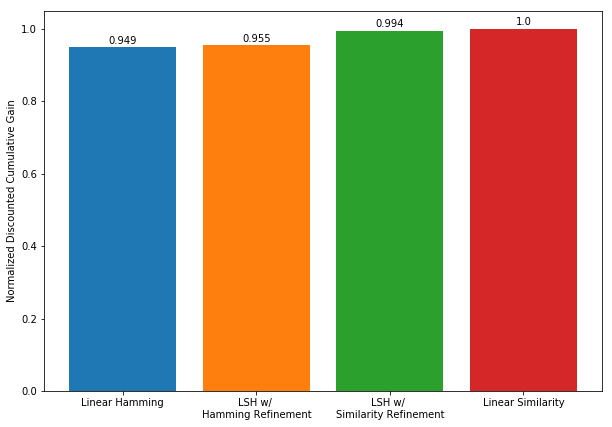

In [22]:
plt.figure(figsize=(10,7))
for i,(score,name) in enumerate(zip(ndcg_all,ndcg_names)):
    plt.bar([i],score) #,label=name)
    plt.text(i,score+0.01,str(round(score,3)),horizontalalignment="center")
#plt.legend()
plt.xticks(np.arange(i+1),ndcg_names)
plt.ylabel("Normalized Discounted Cumulative Gain")
plt.show()

## 3.3 Cosine Similarity

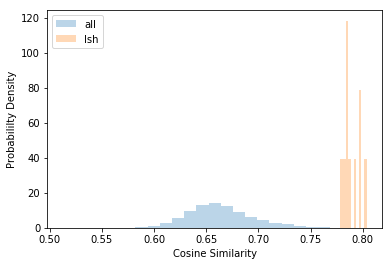

In [23]:
plt.hist(sims,bins=25,alpha=0.3,density=True,label="all")
plt.hist(sims[rank_3_lsh_ip],alpha=0.3,density=True,label="lsh")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Probabililty Density")
plt.show()

## 3.4 Timing

In [24]:
%%timeit
model.approx_top_k(q,k,refine="hamming")

36.2 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
model.approx_top_k(q,k,refine="innerprod")

119 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit
model.exact_top_k(q,k)

46.4 ms ± 726 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3.5 Visual Results

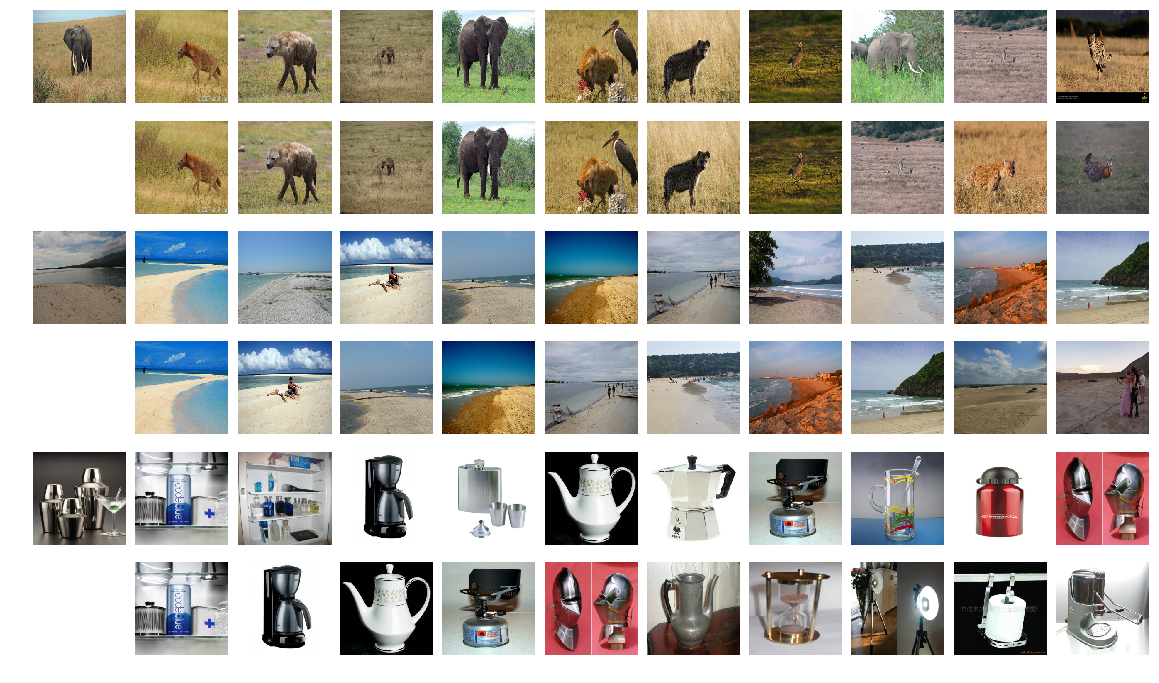

In [27]:
QUERIES_PER_PLOT = 3
PLOTS_PER_QUERY = 10

fig,ax = plt.subplots(2*QUERIES_PER_PLOT,1+PLOTS_PER_QUERY,sharex=True,sharey=True,figsize=(20,12))

for i in range(QUERIES_PER_PLOT):
    base_row = 2*i
    
    #Do Query
    q_index = np.random.randint(0,n)
    q = copy.deepcopy(X[:,q_index:q_index+1])
    rank_0_opt = model.exact_top_k(q,PLOTS_PER_QUERY+1)[1:]
    rank_3_lsh_ip = model.approx_top_k(q,PLOTS_PER_QUERY+1,refine="innerprod")[1:]
    
    #Query
    plt.sca(ax[base_row][0])
    plt_img(q_index)
    
    #Turn off axis below query
    ax[base_row+1][0].axis('off')

    for j in range(PLOTS_PER_QUERY):
        #Exact
        plt.sca(ax[base_row][1+j])
        plt_img(rank_0_opt[j])

        #Approximate
        plt.sca(ax[base_row+1][1+j])
        plt_img(rank_3_lsh_ip[j])
        

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()